This notebook shows a basic pipeline for the NLP task of text classification.<br>
Specifically it tries to classify wheter a tweet describes a real or fake disaster.

The pipeline is composed of:
* Cleaning and pre-preocessing
* Feature engineering
* Pre-trained word-embedding model
* BiLSTM RNN model

# Imports

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

from copy import deepcopy
import gc

import nltk
from nltk.tokenize import TweetTokenizer  # Twitter-aware tokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

import torch
import torch.nn as nn

from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Cleaning and pre-processing functions

#### Text cleaning

In [2]:
def _normalize_tweet(text):
    """Returns a normalized versions of text."""

    # change hyperlinks to '<url>' tokens
    output = re.sub(r'http[s]{0,1}://t.co/[a-zA-Z0-9]+\b', '<url>', text)
    
    # separate all '#' signs from following word with one whitespace
    output = re.sub(r'#(\w+)', r'# \1', output)

    return output

In [3]:
def _tokenize(tokenizer, string):
    """Tokenizes a sentence, but leave hastags (#) and users (@)"""
    
    tokenized = tokenizer.tokenize(string)
    return tokenized

In [4]:
def _numbers_to_number_tokens(tokenized_string, num_token='<number>'):
    """Returns the tokenized string (list) with numbers replaced by a numbet token."""
    
    # create a list of (word, POS-tags) tuples
    pos_tagged = nltk.pos_tag(tokenized_string)
    
    # find indices of number POS tags
    num_indices = [idx for idx in range(len(pos_tagged)) if pos_tagged[idx][1] == 'CD']
    
    # replace numbers by token
    for idx in num_indices:
        tokenized_string[idx] = num_token
        
    return tokenized_string    

In [5]:
def preprocess_text(tokenizer, string):
    """Executes all text cleaning functions."""
    
    return _numbers_to_number_tokens(_tokenize(tokenizer, _normalize_tweet(string)))

#### Keyword cleaning

In [6]:
def preprocess_keyword(keyword):
    """Returns a clean, tokenized keyword."""
    
    # return None if keywors is np.nan
    if type(keyword) == np.float and np.isnan(keyword):
        return
    
    # replace '%20' with whitespace, lower, and tokenize
    output = re.sub(r'%20', ' ', keyword)
    output = output.lower()
    output = output.split()
    return output

# Feature engineering functions

In [7]:
def count_all_caps(text):
    """Returns an integer denoting number of ALL-CAPS words (e.g. 'CANADA', 'WELCOME')."""

    return len([word for word in text.split() if word.isupper()])

In [8]:
def count_capitalized(text):
    """Returns an integer denoting number of capitalized words (e.g. 'Beer', 'Obama')."""

    return len([word for word in text.split() if word.istitle()])

In [9]:
def count_words(text):
    """Returns an integer denoting number of words in tweet (before normalizing)."""

    return len(text.split())

In [10]:
def sentiment_analyze_df(df, column):
    """Adds 4 columns of sentiment analysis scores to input DataFrame. changes occur inplace."""

    # instantiate a sentiment anlayzer
    sid = SentimentIntensityAnalyzer()
    
    # instantiate a matrix and populate it with scores of each of df[column]
    output_values = np.zeros((len(df), 4))
    for tup in df.itertuples():
        output_values[tup.Index, :] = list(sid.polarity_scores(' '.join(getattr(tup, column))).values())
    
    # adding column to input DataFrame
    for idx, col in enumerate(['sent_neg', 'sent_neu', 'sent_pos', 'sent_compound']):
        df[col] = output_values[:, idx]

# Word embedding functions

#### Text embedding

In [11]:
def _get_word_vec(embedding_model, use_norm, word):
    """
    Returns a normalized embedding vector of input word.
    
    Takes care of special cases.
    <url> tokens are already taken care of in normalization.
    """

    if word[0] == '@':
        return embedding_model.word_vec('<user>', use_norm=use_norm)
        
    elif word == '#':
        return embedding_model.word_vec('<hashtag>', use_norm=use_norm)

    elif word in embedding_model.vocab:
        return embedding_model.word_vec(word, use_norm=use_norm)

    else:
        return embedding_model.word_vec('<UNK>', use_norm=use_norm)

In [12]:
def _text_to_vectors(embedding_model, use_norm, tokenized_text):
    """Returns tweet's words' embedding vector.s"""

    vectors = [_get_word_vec(embedding_model, use_norm, word) for word in tokenized_text]
    vectors = np.array(vectors)
    
    return vectors

In [13]:
def _trim_and_pad_vectors(text_vectors, embedding_dimension, seq_len):
    """Returns a padded matrix of text embedding vectors with dimensions (seq_len, embedding dimensions)."""

    # instantiate 0's matrix
    output = np.zeros((seq_len, embedding_dimension))

    # trim long tweets to be seq_len long
    trimmed_vectors = text_vectors[:seq_len]

    # determine index of end of padding and beginning of tweet embedding
    end_of_padding_index = seq_len - trimmed_vectors.shape[0]

    # pad if needed, by replacing last rows with the tweet's words' embedding vectors
    output[end_of_padding_index:] = trimmed_vectors

    return output

In [14]:
def embedding_preprocess(embedding_model, use_norm, seq_len, tokenized_text):
    """Returns an embedding representation of input tokenized text, by executing text embedding functions."""
    
    # get matrix of tweet's words' embedding vectors (tweet length, embedding_dimension)
    text_vectors = _text_to_vectors(embedding_model, use_norm, tokenized_text)
    
    output = _trim_and_pad_vectors(text_vectors, embedding_model.vector_size, seq_len)
    
    return output

#### Keyword embedding

In [15]:
def keyword_to_avg_vector(embedding_model, use_norm, tokenized_keyword):
    """Returns keyword(s') average embedding vector."""
    
    # return a vector of zeros if tokenized_keyword is None
    if tokenized_keyword is None:
        return np.zeros((1, embedding_model.vector_size))
    
    # otherwise, calculate average embedding vector
    vectors = [_get_word_vec(embedding_model, use_norm, word) for word in tokenized_keyword]
    vectors = np.array(vectors)
    avg_vector = np.mean(vectors, axis=0)
    avg_vector = avg_vector.reshape((1, embedding_model.vector_size))
    return avg_vector

# Embedding model preparation

In [16]:
# load a pre-trained model, which was trained on twitter
model_glove_twitter = api.load("glove-twitter-100")

In [17]:
# create a random vector, to represent <UNK> token (unseen word)
random_vec_for_unk = np.random.uniform(-1, 1, size=model_glove_twitter.vector_size).astype('float32')
random_vec_for_unk = random_vec_for_unk.reshape(1,model_glove_twitter.vector_size)
random_vec_for_unk

array([[-0.28576016, -0.41864532, -0.8572179 , -0.07615124, -0.01906447,
         0.5000973 , -0.15887319, -0.3596618 , -0.44722417, -0.70458776,
         0.73015004,  0.05821599, -0.23607884, -0.18747637, -0.4541461 ,
         0.9112709 , -0.82176924, -0.41803637,  0.48593888, -0.81265324,
         0.5378028 , -0.8198196 , -0.9078774 ,  0.7692098 ,  0.12528239,
         0.1299107 , -0.16800979,  0.3341448 , -0.6440562 ,  0.05042027,
        -0.7272799 ,  0.0284716 , -0.57182777,  0.2243131 , -0.4119883 ,
         0.5968199 , -0.7718093 ,  0.6765512 ,  0.7879301 , -0.37710363,
        -0.7303882 , -0.37137026,  0.5668098 , -0.9827039 , -0.70348996,
        -0.12073211,  0.6882181 , -0.01113986, -0.5766474 ,  0.2807778 ,
         0.32177916, -0.7448273 , -0.58350426, -0.9508358 , -0.4289282 ,
         0.972692  , -0.17104867,  0.51400745,  0.6396802 ,  0.6916307 ,
         0.8134772 , -0.6947541 ,  0.8841656 , -0.5825879 ,  0.6819101 ,
         0.87084514,  0.7757009 , -0.8770419 ,  0.0

In [18]:
model_glove_twitter.most_similar(random_vec_for_unk)

[('essencial', 0.4293496310710907),
 ('faça-nos', 0.4135913550853729),
 ('جوابه', 0.3919649124145508),
 ('åpent', 0.3814193606376648),
 ('أصدقائك', 0.37760499119758606),
 ('واختلفنا', 0.3730763792991638),
 ('يدقق', 0.36674734950065613),
 ('تضاعفت', 0.3653828501701355),
 ('貸金業者', 0.3620840907096863),
 ('勝つのは氷帝', 0.3615989685058594)]

In [19]:
# add the random vector to model
model_glove_twitter.add(['<UNK>'], random_vec_for_unk, replace=True)

In [20]:
# compute noramlized vectors, and replace originals
model_glove_twitter.init_sims(replace=True)

# Pre-processing

In [21]:
TRAIN_SET_PATH = 'Data\\train.csv'

In [22]:
train_df = pd.read_csv(TRAIN_SET_PATH)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Cleaning

In [23]:
# create a tokenizer which lowercases, reduces length of and preserves user handles ('@user')
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=False) 

In [24]:
# normalize and tokenize texts
train_df['tok_norm_text'] = [preprocess_text(tokenizer, text) for text in train_df['text']]

In [25]:
train_df['keyword'] = train_df['keyword'].apply(preprocess_keyword)

#### Feature engineering

In [26]:
train_df['num_all_caps'] = train_df['text'].apply(count_all_caps)
train_df['num_caps'] = train_df['text'].apply(count_capitalized)
train_df['num_words'] = train_df['text'].apply(count_words)

In [27]:
# create a scaler to make all features be in range [-1, 1], thus suitable for a newural network model
scaler = MinMaxScaler(feature_range=(-1, 1))

columns_to_scale = ['num_all_caps', 'num_caps', 'num_words']
scaler.fit(train_df[columns_to_scale])
train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])

In [28]:
# create sentiment analysis feautres
sentiment_analyze_df(train_df, 'tok_norm_text')

In [29]:
train_df.head()

,id,keyword,location,text,target,tok_norm_text,num_all_caps,num_caps,num_words,sent_neg,sent_neu,sent_pos,sent_compound
0,1,None,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #, ea...",-0.92,-0.565217,-0.200000,0.000,0.851,0.149,0.2732
1,4,None,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, ., canada]",-1.00,-0.565217,-0.600000,0.286,0.714,0.000,-0.3400
2,5,None,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, ', shelter, in, pl...",-1.00,-0.826087,0.400000,0.095,0.905,0.000,-0.2960
3,6,None,NaN,"13,000 people receive #wildfires evacuation or...",1,"[<number>, people, receive, #, wildfires, evac...",-1.00,-0.913043,-0.533333,0.000,1.000,0.000,0.0000
4,7,None,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #, ...",-1.00,-0.739130,0.000000,0.000,1.000,0.000,0.0000


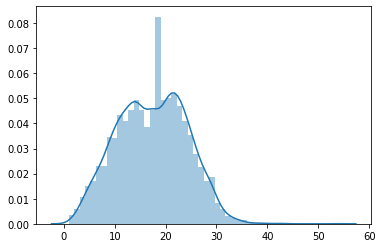

In [30]:
sns.distplot([len(tok) for tok in train_df['tok_norm_text']])

It seems like most of the texts are shorter than 35 words.<br>
Thus, a reasonable compromise between data loss and computational complexity will be<br>
choosing the maximum length of sequences to be 35, i.e. trimming text after the 35'th word.

#### Textual feautres to word embedding representation

In [31]:
sequence_max_length = 30

In [32]:
train_df['text_embedding'] = [
    embedding_preprocess(
        embedding_model=model_glove_twitter, use_norm=True, seq_len=sequence_max_length, tokenized_text=text)
    for text in train_df['tok_norm_text']
]

In [33]:
train_df['keyword_embedding'] = [
    keyword_to_avg_vector(embedding_model=model_glove_twitter, use_norm=True, tokenized_keyword=keyword)
    for keyword in train_df['keyword']
]

In [34]:
train_df.head()

,id,keyword,location,text,target,tok_norm_text,num_all_caps,num_caps,num_words,sent_neg,sent_neu,sent_pos,sent_compound,text_embedding,keyword_embedding
0,1,None,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #, ea...",-0.92,-0.565217,-0.200000,0.000,0.851,0.149,0.2732,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,4,None,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, ., canada]",-1.00,-0.565217,-0.600000,0.286,0.714,0.000,-0.3400,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,5,None,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, ', shelter, in, pl...",-1.00,-0.826087,0.400000,0.095,0.905,0.000,-0.2960,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,6,None,NaN,"13,000 people receive #wildfires evacuation or...",1,"[<number>, people, receive, #, wildfires, evac...",-1.00,-0.913043,-0.533333,0.000,1.000,0.000,0.0000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,7,None,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #, ...",-1.00,-0.739130,0.000000,0.000,1.000,0.000,0.0000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


#### Create one embedding representation of all chosen features

In [35]:
def _single_values_repeat(seq_len, static_single_values):
    """Returns a numpy array containing seq_len-repeated values."""
    
    output = static_single_values.reshape((1, len(static_single_values)))
    output = np.repeat(output, seq_len, axis=0)
    return output

In [36]:
def _static_embedding_repeat(seq_len, static_embedding_values):
    """Return a numpy array os stacked static embedding vectors."""
    
    horizontally_stacked = np.hstack(static_embedding_values)
    output = np.repeat(horizontally_stacked, seq_len, axis=0)
    return output

In [37]:
def concatenate_embeddings(df, embedding_model, seq_len, sequence_embedding_col, static_embedding_cols, static_singles_cols):
    """Returns one embedding representation of all features - main sequence, static embedded featues, and single values."""
    
    emb_dim = embedding_model.vector_size
    
    # instantiate output matrix
    output = np.zeros((len(df), seq_len, len(static_singles_cols) + len(static_embedding_cols) * emb_dim + emb_dim))
    
    for idx, row in df.iterrows():
        
        single_vals = _single_values_repeat(seq_len, row[static_singles_cols].values)
        static_emb_vals = _static_embedding_repeat(seq_len, row[static_embedding_cols])
        seq_emb_vals = row[sequence_embedding_col]

        # horizontally stack embeddings and features
        row_embedding = np.hstack((single_vals, static_emb_vals, seq_emb_vals))

        output[idx, :, :] = row_embedding
        
    return output

In [38]:
# Create one embedding representation of all chosen features
embedding_matrix = concatenate_embeddings(
    df=train_df, embedding_model=model_glove_twitter, seq_len=sequence_max_length,
    sequence_embedding_col='text_embedding',
    static_embedding_cols=['keyword_embedding'],
    static_singles_cols=['num_all_caps', 'num_caps', 'num_words', 'sent_neg', 'sent_neu', 'sent_pos', 'sent_compound'])

In [39]:
embedding_matrix.shape

(7613, 30, 207)

# Neural-network creation and utility functions

In [40]:
class BiLSTM(nn.Module):
    """Extends nn.Module with some methods and attributes. Should be inherited by specific network subclasses."""
    
    """A pyTorch Bi-Directional LSTM RNN implementation, which inherits BaseNN."""

    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes, batch_size, dropout, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        self.dropout = nn.Dropout(p=dropout)

        self.lstm = nn.LSTM(
            input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout, bidirectional=True)
        
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        
        self.device = device
        
        # instantiate lists for evaluating and plotting
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        
        # an attribute to hold model's best weights (used for evaluating)
        self.best_weights = deepcopy(self.state_dict())

    def _init_hidden(self, current_batch_size):
        """Sets initial hidden and cell states (for LSTM)."""

        h0 = torch.zeros(self.num_layers * 2, current_batch_size, self.hidden_dim).to(self.device)
        c0 = torch.zeros(self.num_layers * 2, current_batch_size, self.hidden_dim).to(self.device)
        return h0, c0

    def forward(self, x):
        """Forward step."""

        # Forward propagate LSTM
        h, c = self._init_hidden(current_batch_size=x.size(0))
        out, _ = self.lstm(x, (h, c))

        # dropout
        out = self.dropout(out)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out
    
    def predict(self, x: torch.tensor):
        """Return a tensor of predictions of tensor x."""

        class_predictions = self(x).data
        _, predicted = torch.max(class_predictions, dim=1)
        return predicted

    def _train_evaluate(self, X_train, y_train, X_val, y_val, criterion):
        """
        Evaluates model during training time, and returns train_loss, train_acc, val_loss, val_acc.

        Using item() to extract a number from a tensor containing a single value, is mandatory to avoid memory overflow.
        """

        # set model to evaluation mode
        self.eval()

        # calculate accuracy and loss of train set and append to lists
        epoch_train_acc = (self.predict(X_train) == y_train).sum().item() / y_train.shape[0]
        epoch_train_loss = criterion(self(X_train), y_train).item()
        self.train_acc.append(epoch_train_acc)
        self.train_loss.append(epoch_train_loss)

        # calculate accuracy and loss of validation set, and append to lists
        if X_val is not None and y_val is not None:
            epoch_val_acc = (self.predict(X_val) == y_val).sum().item() / y_val.shape[0]
            epoch_val_loss = criterion(self(X_val), y_val).item()
            self.val_acc.append(epoch_val_acc)
            self.val_loss.append(epoch_val_loss)

            # return all loss and accuracy values
            return epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc

        # return train set loss and accuracy values, if there is no validation set
        return epoch_train_loss, epoch_train_acc, None, None

    def best_epoch(self):
        """Returns a dictionary containing best epochs corresponding to train_loss, train_acc, val_loss, val_acc."""

        best_train_loss_epoch = np.argmin(np.array(self.train_loss)) + 1
        best_train_acc_epoch = np.argmax(np.array(self.train_acc)) + 1

        output = {'best Training loss epoch': best_train_loss_epoch, 'best Training accuracy epoch': best_train_acc_epoch}

        if len(self.val_loss) > 0:
            best_val_loss_epoch = np.argmin(np.array(self.val_loss))
            best_val_acc_epoch = np.argmax(np.array(self.val_acc))

            output.update({
                'best Validation loss epoch': best_val_loss_epoch, 'best Validation accuracy epoch': best_val_acc_epoch
            })

        return output

    def get_num_parameters(self):
        """Returns a dictionary containing the number of total and trainable parameters."""

        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return {'total_parameters': total_params, 'trainable_parameters': trainable_params}

    @staticmethod
    def _print_progress(epoch, train_loss, train_acc, val_loss, val_acc, improved, verbose=False):
        """Prints the training progress."""

        output = f'Epoch {str(epoch + 1).zfill(3)}:'
        output += f'\n\t Training   Loss: {str(train_loss)[:5]} | Accuracy: {str(train_acc)[:5]}.'

        if val_loss is not None and val_acc is not None:
            output += f'\n\t Validation Loss: {str(val_loss)[:5]} | Accuracy: {str(val_acc)[:5]}.'

        if improved:
            output += f' Improvement!'

        if verbose:
            print(output)

    def fit(self, X_train, y_train, X_val, y_val, epoch_num, criterion, optimizer, verbose=False):
        """
        Trains the model.

        :param X_train, y_train: training set.
        :param X_val, y_val: optional. validation set.
        :param epoch_num: number of epochs to perform.
        :param criterion: loss functions.
        :param optimizer: optimizer.
        :param verbose: a boolean to determine whether to print training progress.
        """

        # a variable to determine whether to update best weights (and report progress)
        best_acc = 0.0

        # split dataset to batches
        X_train_tensor_batches = torch.split(X_train, self.batch_size)
        y_train_tensor_batches = torch.split(y_train, self.batch_size)

        for epoch in range(epoch_num):

            # set model to train mode (at end of each epoch model is set to evaluation mode)
            self.train()

            for i, (X_batch, y_batch) in enumerate(zip(X_train_tensor_batches, y_train_tensor_batches)):

                # Forward pass
                outputs = self(X_batch)
                loss = criterion(outputs, y_batch)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # calculate accuracy and loss of train and validation set (if validation set is  None, values are None)
            train_loss, train_acc, val_loss, val_acc = self._train_evaluate(X_train, y_train, X_val, y_val, criterion)

            # a boolean to determine the correct accuracy to consider for progress (Validation ot Training)
            if X_val is not None and y_val is not None:
                accuracy = val_acc
            else:
                accuracy = train_acc

            # if accuracy outperforms previous best accuracy, print and update best accuracy and model's best weights
            if accuracy > best_acc:
                self._print_progress(epoch, train_loss, train_acc, val_loss, val_acc, improved=True, verbose=verbose)
                best_acc = accuracy
                self.best_weights = deepcopy(self.state_dict())

            # else, print
            else:
                self._print_progress(epoch, train_loss, train_acc, val_loss, val_acc, improved=False, verbose=verbose)

        # uncomment next line to restore best weights (determined by best accuracy)
        #self.load_state_dict(best_weights)
        gc.collect()

In [41]:
def plot_graphs(model):
    plt.figure(figsize=(6, 12))

    plt.subplot(311)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1, len(model.train_acc)+1), model.train_acc, label="Train")
    plt.plot(range(1, len(model.val_acc)+1), model.val_acc, label="Validation")

    plt.xticks(np.arange(0, len(model.train_acc)+1, 5))
    plt.legend()

    plt.subplot(312)
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1, len(model.train_loss)+1), model.train_loss, label="Train")
    plt.plot(range(1, len(model.val_loss)+1), model.val_loss, label="Validation")

    plt.xticks(np.arange(0, len(model.train_acc)+1, 5))
    plt.legend()

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

# Running the network

At first, I split the train data to train and test set (the test set is called held-out set):

In [42]:
X_train_val, X_held_out_set, y_train_val, y_held_out_set = train_test_split(
    embedding_matrix, train_df['target'].values, test_size=0.1)

In [43]:
# determines which device to mount the model to
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [44]:
# convert above LSTM arrays to tensors to be used in BiLSTM Neural Network
X_train_val = torch.from_numpy(X_train_val).float().to(device)
X_held_out_set = torch.from_numpy(X_held_out_set).float().to(device)
y_train_val = torch.from_numpy(y_train_val).long().to(device)
y_held_out_set = torch.from_numpy(y_held_out_set).long().to(device)

I used the train-val set to perform 10-fold cross validation to tune the hyper-parameters of the network. <br>
The 10-fold cross validation is left out of the notebook for readability and order. <br>
The chosen hyper-parameters are as following:

In [45]:
# network hyprer-parameters
embedding_dim = embedding_matrix.shape[2]  # depends on used embedding model
hidden_size = 50  # 50 best
num_layers = 2  # 2 best
num_classes = 2  # 2 mandatory
batch_size = 256  # 256 best
dropout = 0.3  # 0.3 is probably best

In [46]:
# learning hyprer-parameters
num_epochs = 20  # 20 best (to avoid overfitting)
learning_rate = 0.0005  # 0.0005 best
weight_decay = 0.0005  # 0.0005 best

To show the results, I use the train-val data to train the network, and use the held-out to test it:

In [47]:
# instantiate Model, Loss and Optimizer
bilstm = BiLSTM(embedding_dim, hidden_size, num_layers, num_classes, batch_size, dropout, device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [48]:
bilstm.get_num_parameters()

{'total_parameters': 164602, 'trainable_parameters': 164602}

In [49]:
# train the model
bilstm.fit(
    X_train=X_train_val, y_train=y_train_val, X_val=X_held_out_set, y_val=y_held_out_set,
    epoch_num=num_epochs, criterion=criterion, optimizer=optimizer, verbose=True)

Epoch 001:
	 Training   Loss: 0.666 | Accuracy: 0.569.
	 Validation Loss: 0.664 | Accuracy: 0.573. Improvement!
Epoch 002:
	 Training   Loss: 0.575 | Accuracy: 0.708.
	 Validation Loss: 0.559 | Accuracy: 0.708. Improvement!
Epoch 003:
	 Training   Loss: 0.521 | Accuracy: 0.751.
	 Validation Loss: 0.500 | Accuracy: 0.766. Improvement!
Epoch 004:
	 Training   Loss: 0.489 | Accuracy: 0.772.
	 Validation Loss: 0.474 | Accuracy: 0.791. Improvement!
Epoch 005:
	 Training   Loss: 0.462 | Accuracy: 0.789.
	 Validation Loss: 0.457 | Accuracy: 0.787.
Epoch 006:
	 Training   Loss: 0.437 | Accuracy: 0.804.
	 Validation Loss: 0.434 | Accuracy: 0.813. Improvement!
Epoch 007:
	 Training   Loss: 0.427 | Accuracy: 0.812.
	 Validation Loss: 0.420 | Accuracy: 0.811.
Epoch 008:
	 Training   Loss: 0.423 | Accuracy: 0.813.
	 Validation Loss: 0.415 | Accuracy: 0.812.
Epoch 009:
	 Training   Loss: 0.413 | Accuracy: 0.820.
	 Validation Loss: 0.406 | Accuracy: 0.813.
Epoch 010:
	 Training   Loss: 0.408 | Accura

The training graph:

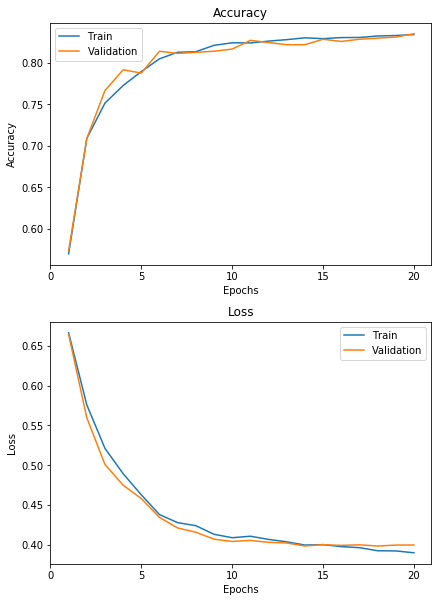

In [50]:
plot_graphs(bilstm)

As we now know our network is doing it's job properly, I train a network again, using all the training-data:

In [51]:
del(bilstm)

In [52]:
X_train = torch.from_numpy(embedding_matrix).float().to(device)
y_train = torch.from_numpy(train_df['target'].values).long().to(device)

In [53]:
# instantiate Model, Loss and Optimizer
bilstm = BiLSTM(embedding_dim, hidden_size, num_layers, num_classes, batch_size, dropout, device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [54]:
# train the model
bilstm.fit(
    X_train=X_train, y_train=y_train, X_val=None, y_val=None,
    epoch_num=num_epochs, criterion=criterion, optimizer=optimizer, verbose=True)

Epoch 001:
	 Training   Loss: 0.675 | Accuracy: 0.570. Improvement!
Epoch 002:
	 Training   Loss: 0.644 | Accuracy: 0.642. Improvement!
Epoch 003:
	 Training   Loss: 0.548 | Accuracy: 0.725. Improvement!
Epoch 004:
	 Training   Loss: 0.507 | Accuracy: 0.758. Improvement!
Epoch 005:
	 Training   Loss: 0.479 | Accuracy: 0.778. Improvement!
Epoch 006:
	 Training   Loss: 0.452 | Accuracy: 0.800. Improvement!
Epoch 007:
	 Training   Loss: 0.440 | Accuracy: 0.805. Improvement!
Epoch 008:
	 Training   Loss: 0.431 | Accuracy: 0.810. Improvement!
Epoch 009:
	 Training   Loss: 0.427 | Accuracy: 0.808.
Epoch 010:
	 Training   Loss: 0.418 | Accuracy: 0.817. Improvement!
Epoch 011:
	 Training   Loss: 0.443 | Accuracy: 0.801.
Epoch 012:
	 Training   Loss: 0.415 | Accuracy: 0.818. Improvement!
Epoch 013:
	 Training   Loss: 0.414 | Accuracy: 0.819. Improvement!
Epoch 014:
	 Training   Loss: 0.406 | Accuracy: 0.822. Improvement!
Epoch 015:
	 Training   Loss: 0.405 | Accuracy: 0.826. Improvement!
Epoch 

The training graph (note that this time there is no validation data to test on):

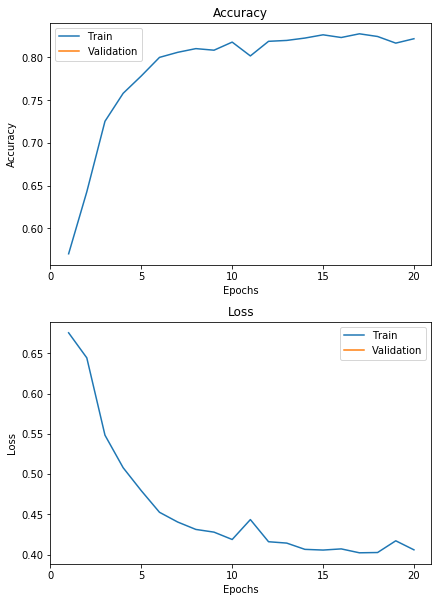

In [55]:
plot_graphs(bilstm)

# Predicting test set

In [56]:
TEST_SET_PATH = 'Data\\test.csv'

In [57]:
test_df = pd.read_csv(TEST_SET_PATH)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [58]:
# normalize and tokenize texts and keywords
test_df['tok_norm_text'] = [preprocess_text(tokenizer, text) for text in test_df['text']]
test_df['keyword'] = test_df['keyword'].apply(preprocess_keyword)

In [59]:
# feature extraction
test_df['num_all_caps'] = test_df['text'].apply(count_all_caps)
test_df['num_caps'] = test_df['text'].apply(count_capitalized)
test_df['num_words'] = test_df['text'].apply(count_words)

test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

sentiment_analyze_df(test_df, 'tok_norm_text')

In [60]:
#text embedding
test_df['text_embedding'] = [
    embedding_preprocess(
        embedding_model=model_glove_twitter, use_norm=True, seq_len=sequence_max_length, tokenized_text=text)
    for text in test_df['tok_norm_text']
]

In [61]:
#keyword embedding
test_df['keyword_embedding'] = [
    keyword_to_avg_vector(embedding_model=model_glove_twitter, use_norm=True, tokenized_keyword=keyword)
    for keyword in test_df['keyword']
]

In [62]:
test_df.head()

,id,keyword,location,text,tok_norm_text,num_all_caps,num_caps,num_words,sent_neg,sent_neu,sent_pos,sent_compound,text_embedding,keyword_embedding
0,0,None,NaN,Just happened a terrible car crash,"[just, happened, a, terrible, car, crash]",-1.00,-0.913043,-0.666667,0.659,0.341,0.000,-0.7003,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2,None,NaN,"Heard about #earthquake is different cities, s...","[heard, about, #, earthquake, is, different, c...",-1.00,-0.913043,-0.466667,0.000,0.734,0.266,0.4404,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,3,None,NaN,"there is a forest fire at spot pond, geese are...","[there, is, a, forest, fire, at, spot, pond, ,...",-0.92,-0.913043,0.200000,0.251,0.749,0.000,-0.6159,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,9,None,NaN,Apocalypse lighting. #Spokane #wildfires,"[apocalypse, lighting, ., #, spokane, #, wildf...",-1.00,-0.826087,-0.800000,0.000,1.000,0.000,0.0000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,11,None,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kills, <number>, in, china...",-1.00,-0.652174,-0.533333,0.333,0.667,0.000,-0.5423,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [63]:
# Create one embedding representation of all chosen features
test_embedding_matrix = concatenate_embeddings(
    df=test_df, embedding_model=model_glove_twitter, seq_len=sequence_max_length,
    sequence_embedding_col='text_embedding',
    static_embedding_cols=['keyword_embedding'],
    static_singles_cols=['num_all_caps', 'num_caps', 'num_words', 'sent_neg', 'sent_neu', 'sent_pos', 'sent_compound'])

In [64]:
X_test = torch.from_numpy(test_embedding_matrix).float().to(device)

In [65]:
# predict
preds = bilstm.predict(X_test)

In [66]:
# put predictions and id's in DataFrame
final_preds = preds.cpu().numpy().reshape(-1,1)
ids = test_df['id'].values.reshape(-1,1)
data = np.hstack((ids, final_preds))

submission_df = pd.DataFrame(data=data,columns = ['id', 'target'])

In [67]:
submission_df.to_csv('submission.csv', index=False)